## Fitting Curly's sphere in water sims
in order to check consistency with my simulations

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.append(module_path)

import numpy as np

## Plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
## Parameter setting needs to be in cell following mpl import for some reason 
## https://github.com/jupyter/notebook/issues/3385
##
## Default parameters inspired by 
## http://nipunbatra.github.io/2014/08/latexify/
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'magma',
    'axes.grid': False,
    'figure.dpi': 200,  # to adjust notebook inline plot size
    'savefig.dpi': 200,  # to adjust notebook inline plot size
#     'axes.labelsize': 12, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 8, # was 10
#     'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 10,
    'font.size': 8, # was 10
    'legend.fontsize': 8, # was 10
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'text.usetex': True,
    'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
    'figure.max_open_warning':10001
}
mpl.rcParams.update(params)
## For colorbar 
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Get physical constants from Scipy
import scipy.constants as con

## For fitting
import scipy.optimize as opt

## For matlab loading
import scipy.io as sio

## Load custom package modules
from misloc_mispol_package.calc import BEM_simulation_wrapper as bem
from misloc_mispol_package.calc import fitting_misLocalization as fit
from misloc_mispol_package.calc import coupled_dipoles as cp
from misloc_mispol_package.optics import diffraction_int as diffi
from misloc_mispol_package.optics import fibonacci as fib
from misloc_mispol_package.parameterize import spec_fit as spit

## Some useful numerical constants
hbar = con.physical_constants['Planck constant over 2 pi in eV s'][0]
c = con.physical_constants['speed of light in vacuum'][0]*1e2 #cm/m

m_per_nm = fit.m_per_nm

eps_b = 1.778 ## Water
cm_per_nm = 1E-7

hres_obs_pts = diffi.observation_points(
    -480*m_per_nm, 480*m_per_nm, -480*m_per_nm, 480*m_per_nm, 201)

In [3]:
def label_offset(ax, axis="y"):
    if axis == "y":
        fmt = ax.yaxis.get_major_formatter()
        ax.yaxis.offsetText.set_visible(False)
        set_label = ax.set_ylabel
        label = ax.get_ylabel()

    elif axis == "x":
        fmt = ax.xaxis.get_major_formatter()
        ax.xaxis.offsetText.set_visible(False)
        set_label = ax.set_xlabel
        label = ax.get_xlabel()

    def update_label(event_axes):
        offset = fmt.get_offset()
        if offset == '':
            set_label("{}".format(label))
        else:
            set_label("{} ({})".format(label, offset))
        return

    ax.callbacks.connect("ylim_changed", update_label)
    ax.callbacks.connect("xlim_changed", update_label)
    ax.figure.canvas.draw()
    update_label(None)
    return


In [4]:
pixel_num = 300
boundary_pixel_coords_in_nm = [
    -750,
    750,
    -750,
    750,
    ]
pixel_size = (
    boundary_pixel_coords_in_nm[1] - boundary_pixel_coords_in_nm[0]
    )/(pixel_num)

exp_obs_pts = diffi.observation_points(
    boundary_pixel_coords_in_nm[0]*cm_per_nm, 
    boundary_pixel_coords_in_nm[1]*cm_per_nm, 
    boundary_pixel_coords_in_nm[2]*cm_per_nm, 
    boundary_pixel_coords_in_nm[3]*cm_per_nm, 
    300,) ## cm_per_m

# img_extent = [
#     boundary_pixel_coords_in_nm[0] - .5*pixel_size,
#     boundary_pixel_coords_in_nm[1] + .5*pixel_size,
#     boundary_pixel_coords_in_nm[2] - .5*pixel_size,
#     boundary_pixel_coords_in_nm[3] + .5*pixel_size,
# ]

In [35]:
def img_extent(field_dict):
    
    ## Define extent in nanometers.
    extent_nm = np.array([
        field_dict['x_image'].min(),
        field_dict['x_image'].max(),
        field_dict['y_image'].min(),
        field_dict['y_image'].max(),])*(1e9) #nm/m

    return extent_nm

In [5]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'simple_sphere_sims_011720',
#     'reanysimulationyouwantmetodo'
    )

In [196]:
import h5py

# AuND_D80_T30_5_6_19_Spectra = {}
# f = h5py.File(
#     os.path.join(path_to_data, "AuND_D80_T30_5_6_19_Spectra.mat"), 
#     'r')

# for key, val in f.items():
#     AuND_D80_T30_5_6_19_Spectra[key] = np.array(val)[0]
    
def load_mat_var_dict(path):
    
    ## Initialize dict
    mat_var_dict = {}
    ## Load file
    f = h5py.File(
        path, 
        'r')
    ## Iterate through hdf5 file and get variables
    for key, val in f.items():
        mat_var_dict[key] = np.array(val)
        
    return mat_var_dict

In [6]:
curly_images = {}

def file_name_base(numstr): 
    return f"AuNS_D40_{numstr:d}_X_01_16_20_ff_at558"

In [7]:
for i in range(21):
    curly_images[i+1] = sio.loadmat(
        os.path.join(path_to_data, 'try1', file_name_base(i+1)+".mat"))

In [8]:
curly_images.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

Let's check out one of these images

In [9]:
curly_images[1].keys()

dict_keys(['__header__', '__version__', '__globals__', 'E2_image_xy', 'x_dip', 'x_image', 'y_dip', 'y_image', 'z_dip'])

In [10]:
curly_images[1]['E2_image_xy'].shape

(300, 300)

In [11]:
array_of_curly_imgs = np.empty((21, 300**2))
for i in range(21):
    array_of_curly_imgs[i] = curly_images[i+1]['E2_image_xy'].ravel()

In [49]:
fit_inst = fit.FitModelToData(
    array_of_curly_imgs, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim',
    sphere_model='MLWA'
    )
the_fit = fit_inst.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (37.201275595863024,-7.902509208783835e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  37.201275595863024 
 ini_y,  -7.902509208783835e-07 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? True
Params modified, OG params: (37.201275595863024, -7.902509208783835e-07, array([1.15641066]))
but now they are: (52.202153529999975, -1.1089082107697971e-06, array([1.15641066]))

 initial guess for molecule 1 location: (107.25065766524324,1.6565659237826539e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  107.25065766524324 
 ini_y,  1.6565659237826539e-06 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? False

 initial guess for molecule 2 location: (129.1228067511028,1.1970559158901245e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  129.1228067511028 
 ini_y,  1.1970559158901245e-06 
 self.quel_a,  52.

In [50]:
the_fit

array([[6.53604317e+01, 8.51684183e-01, 1.56492407e+00],
       [1.09948883e+02, 8.19763944e-02, 1.56958968e+00],
       [1.34349542e+02, 3.17693911e-02, 1.56988822e+00],
       [6.01486151e+01, 4.75568645e+01, 1.21981835e+00],
       [1.00303727e+02, 4.00314861e+01, 1.49586680e+00],
       [1.32273079e+02, 3.50427861e+01, 1.56190802e+00],
       [3.52866965e+01, 5.13253653e+01, 1.14789312e-01],
       [5.75533405e+01, 2.80879431e+01, 4.40889904e-01],
       [7.28118690e+01, 1.28492715e+01, 7.67039780e-01],
       [8.75945132e+01, 6.71492854e+01, 1.47102682e+00],
       [1.26584598e+02, 6.58096561e+01, 1.54358483e+00],
       [3.09216641e+01, 7.01247739e+01, 4.17285802e-01],
       [1.88792518e+01, 8.56782032e+01, 1.45474720e+00],
       [4.67193614e+01, 8.37621647e+01, 1.42414831e+00],
       [8.57846439e+01, 9.20919022e+01, 1.52739543e+00],
       [1.22246059e+02, 9.38201952e+01, 1.52584822e+00],
       [1.97428531e-02, 9.91768749e+01, 1.57055093e+00],
       [2.22752710e+01, 9.89239

(-6.7030274583845975,
 141.07231277088113,
 -5.984087796296367,
 126.15663409214429)

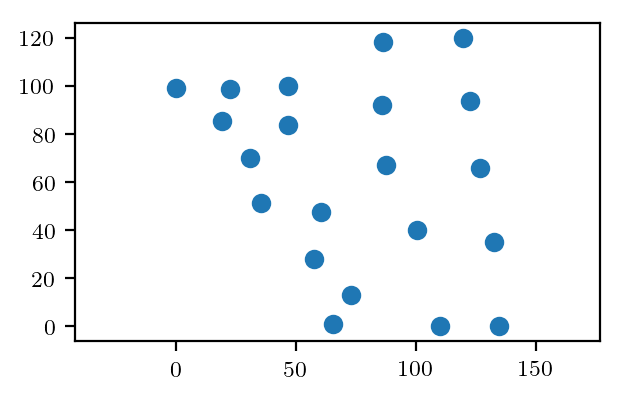

In [53]:
plt.scatter(the_fit.T[0], the_fit.T[1])
plt.scatter(
    *np.meshgrid(np.linspace(0,125,5),np.linspace(0,125,5)),
    alpha=.5)
plt.axis('equal')

### Think that was run at the wrong wavelength, peak seems to move going from Drude to JC

In [55]:
mie_fit_inst = fit.FitModelToData(
    array_of_curly_imgs, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim',
    sphere_model='Mie'
    )
mie_the_fit = mie_fit_inst.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (37.201275595863024,-7.902509208783835e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  37.201275595863024 
 ini_y,  -7.902509208783835e-07 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? True
Params modified, OG params: (37.201275595863024, -7.902509208783835e-07, array([1.18716597]))
but now they are: (52.202153529999975, -1.1089082107697971e-06, array([1.18716597]))

 initial guess for molecule 1 location: (107.25065766524324,1.6565659237826539e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  107.25065766524324 
 ini_y,  1.6565659237826539e-06 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? False

 initial guess for molecule 2 location: (129.1228067511028,1.1970559158901245e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  129.1228067511028 
 ini_y,  1.1970559158901245e-06 
 self.quel_a,  52.

(-7.004915810812594, 132.0049158108126, -7.662879687469553, 132.66287968746954)

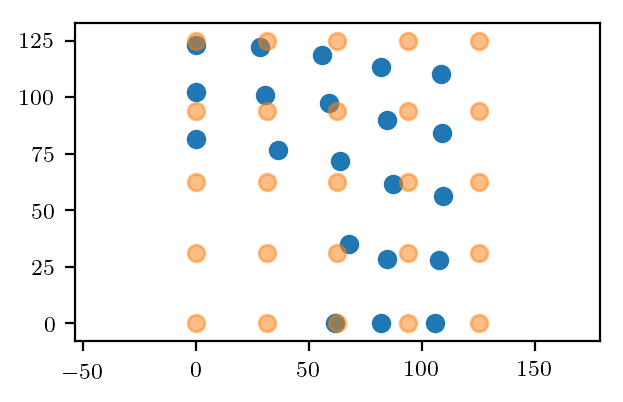

In [62]:
plt.scatter(mie_the_fit.T[0], mie_the_fit.T[1])
plt.scatter(
    *np.meshgrid(np.linspace(0,125,5),np.linspace(0,125,5)),
    alpha=.5)

plt.axis('equal')


In [63]:
mie_fit_inst_NA6 = fit.FitModelToData(
    array_of_curly_imgs, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim_NA6',
    sphere_model='Mie'
    )
mie_the_fit_NA6 = mie_fit_inst_NA6.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (37.201275595863024,-7.902509208783835e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  37.201275595863024 
 ini_y,  -7.902509208783835e-07 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? True
Params modified, OG params: (37.201275595863024, -7.902509208783835e-07, array([0.30345188]))
but now they are: (52.202153529999975, -1.1089082107697971e-06, array([0.30345188]))

 initial guess for molecule 1 location: (107.25065766524324,1.6565659237826539e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  107.25065766524324 
 ini_y,  1.6565659237826539e-06 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? False

 initial guess for molecule 2 location: (129.1228067511028,1.1970559158901245e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  129.1228067511028 
 ini_y,  1.1970559158901245e-06 
 self.quel_a,  52.

Text(0.5, 1.0, 'NA 6')

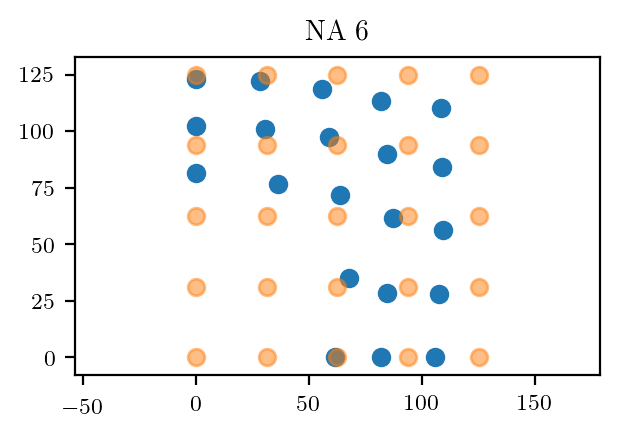

In [64]:
plt.scatter(mie_the_fit_NA6.T[0], mie_the_fit_NA6.T[1])
plt.scatter(
    *np.meshgrid(np.linspace(0,125,5),np.linspace(0,125,5)),
    alpha=.5)

plt.axis('equal')
plt.title('NA 6')

Ah thats right it shouldn't change anything to change NA in the param file. THat should only impact how I run simulations. 

## Try the fit with the gaussian at high energy

In [65]:
mie_fit_inst_wGau = fit.FitModelToData(
    array_of_curly_imgs, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim_wGau',
    sphere_model='Mie'
    )
mie_the_fit_wGau = mie_fit_inst_wGau.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (37.201275595863024,-7.902509208783835e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  37.201275595863024 
 ini_y,  -7.902509208783835e-07 
 self.quel_a,  53.228730000000006 
 self.quel_c,  53.228730000000006 

In quenching zone? True
Params modified, OG params: (37.201275595863024, -7.902509208783835e-07, array([0.25856919]))
but now they are: (53.22872999999999, -1.130715339395475e-06, array([0.25856919]))

 initial guess for molecule 1 location: (107.25065766524324,1.6565659237826539e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  107.25065766524324 
 ini_y,  1.6565659237826539e-06 
 self.quel_a,  53.228730000000006 
 self.quel_c,  53.228730000000006 

In quenching zone? False

 initial guess for molecule 2 location: (129.1228067511028,1.1970559158901245e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  129.1228067511028 
 ini_y,  1.1970559158901245e-06 
 self.quel_a,  5

Text(0.5, 1.0, 'w/gau')

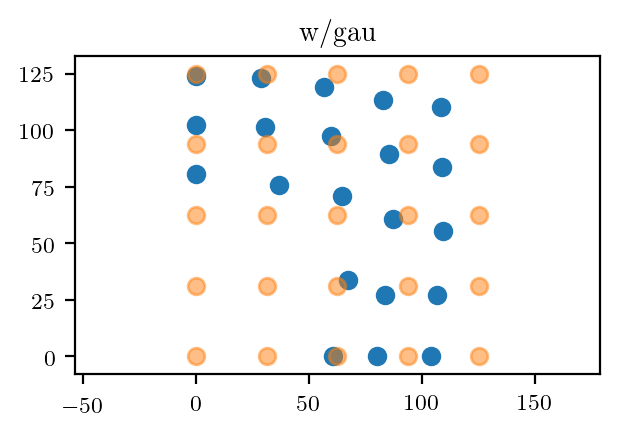

In [76]:
plt.scatter(mie_the_fit_wGau.T[0], mie_the_fit_wGau.T[1])
plt.scatter(
    *np.meshgrid(np.linspace(0,125,5),np.linspace(0,125,5)),
    alpha=.5)

plt.axis('equal')
plt.title('w/gau')

In [77]:
mie_the_fit_wGau

array([[ 6.06943589e+01,  1.62580947e-02,  1.56766118e+00],
       [ 8.00896018e+01, -7.45781942e-02,  1.56998340e+00],
       [ 1.04057440e+02,  1.27348932e-04,  1.57077921e+00],
       [ 6.72896594e+01,  3.36932199e+01,  1.46119448e+00],
       [ 8.34614210e+01,  2.72917121e+01,  1.53573748e+00],
       [ 1.06677941e+02,  2.71923424e+01,  1.53596290e+00],
       [ 5.76228801e-02,  8.06195080e+01,  1.56838025e+00],
       [ 3.65462780e+01,  7.58721483e+01,  1.41170389e+00],
       [ 6.43684419e+01,  7.10479490e+01,  1.45339061e+00],
       [ 8.70525590e+01,  6.05900731e+01,  1.56168954e+00],
       [ 1.08998013e+02,  5.56256111e+01,  1.52525702e+00],
       [-6.74852073e-02,  1.02497271e+02,  1.56992256e+00],
       [ 3.06169952e+01,  1.01291275e+02,  1.50785005e+00],
       [ 5.95187644e+01,  9.74109030e+01,  1.50392641e+00],
       [ 8.51399185e+01,  8.94753461e+01,  1.52003615e+00],
       [ 1.08989464e+02,  8.36671615e+01,  1.50365983e+00],
       [ 5.86144128e-02,  1.24242023e+02

In [79]:
## Let me investigate some of the fit instance parameters 
mie_fit_inst_wGau.__dict__.keys()

dict_keys(['mol_angles', 'rod_angle', 'image_data', 'ini_guess', 'parameters', 'drive_energy_eV', 'eps_inf', 'omega_plasma', 'gamma_drude', 'a_long_meters', 'a_short_meters', 'true_a_un_me', 'is_sphere', 'true_a_de_me', 'eps_b', 'fluo_quench_range', 'fluo_ext_coef', 'fluo_mass_hbar_gamma', 'fluo_nr_hbar_gamma', 'drive_amp', 'alpha0_diag_dyad', 'sphere_model', 'alpha1_diag_dyad', 'el_c', 'el_a', 'sensor_size', 'obs_points', 'drive_I', 'quel_a', 'quel_c', 'model_fit_results', 'x_gau_cen', 'y_gau_cen'])

In [85]:
mie_fit_inst_wGau.drive_energy_eV

2.2185083793472917

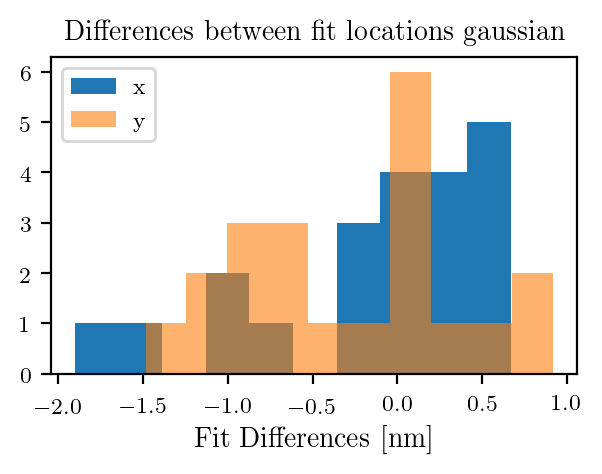

In [73]:
## are those results even different?
plt.hist((mie_the_fit_wGau - mie_the_fit_NA6).T[0], label='x')
# plt.xlabel('x differences')
plt.hist((mie_the_fit_wGau - mie_the_fit_NA6).T[1], label='y', alpha=.6)
plt.xlabel('Fit Differences [nm]')
plt.title('Differences between fit locations gaussian ')
plt.legend()

## Try parameters from fitting my spectrum

In [74]:
mie_fit_inst_wGau_myparams = fit.FitModelToData(
    array_of_curly_imgs, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_bemSim_wGau',
    sphere_model='Mie'
    )
mie_the_fit_wGau_myparams = mie_fit_inst_wGau_myparams.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (37.201275595863024,-7.902509208783835e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  37.201275595863024 
 ini_y,  -7.902509208783835e-07 
 self.quel_a,  51.65820063999999 
 self.quel_c,  51.65820063999999 

In quenching zone? True
Params modified, OG params: (37.201275595863024, -7.902509208783835e-07, array([1.33672631]))
but now they are: (51.658200639999976, -1.0973532501943427e-06, array([1.33672631]))

 initial guess for molecule 1 location: (107.25065766524324,1.6565659237826539e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  107.25065766524324 
 ini_y,  1.6565659237826539e-06 
 self.quel_a,  51.65820063999999 
 self.quel_c,  51.65820063999999 

In quenching zone? False

 initial guess for molecule 2 location: (129.1228067511028,1.1970559158901245e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  129.1228067511028 
 ini_y,  1.1970559158901245e-06 
 self.quel_a,  51.

Text(0.5, 1.0, 'my params')

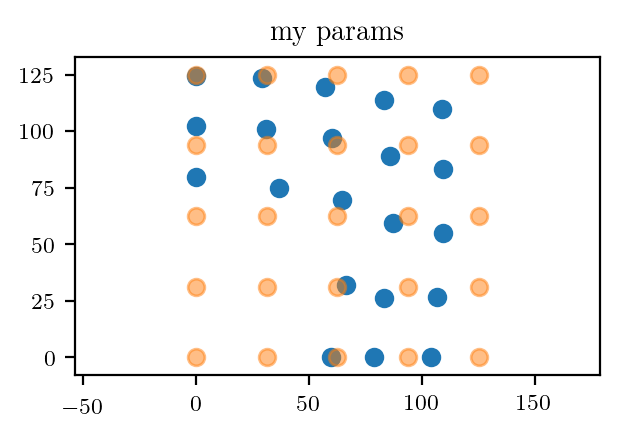

In [75]:
plt.scatter(mie_the_fit_wGau_myparams.T[0], mie_the_fit_wGau_myparams.T[1])
plt.scatter(
    *np.meshgrid(np.linspace(0,125,5),np.linspace(0,125,5)),
    alpha=.5)

plt.axis('equal')
plt.title('my params')

## I should also run my own simulations with the JC parameters

In [87]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)

sim_inst = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmJC_curlySim_wGau_lowerLensDisc',
    simulation_file_name='SphereJC_NoSub_dipDrive_E',
    sphere_model='Mie')
sim_inst.trial_images = sim_inst.calculate_BEM_fields()

mie_fit_mysims_inst_wGau = fit.FitModelToData(
    sim_inst.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim_wGau_lowerLensDisc',
    sphere_model='Mie'
    )
mie_fit_mysims_params_wGau = mie_fit_mysims_inst_wGau.fit_model_to_image_data(
    check_ini=True)

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


Calculating Gaussian centroid with BEM_images


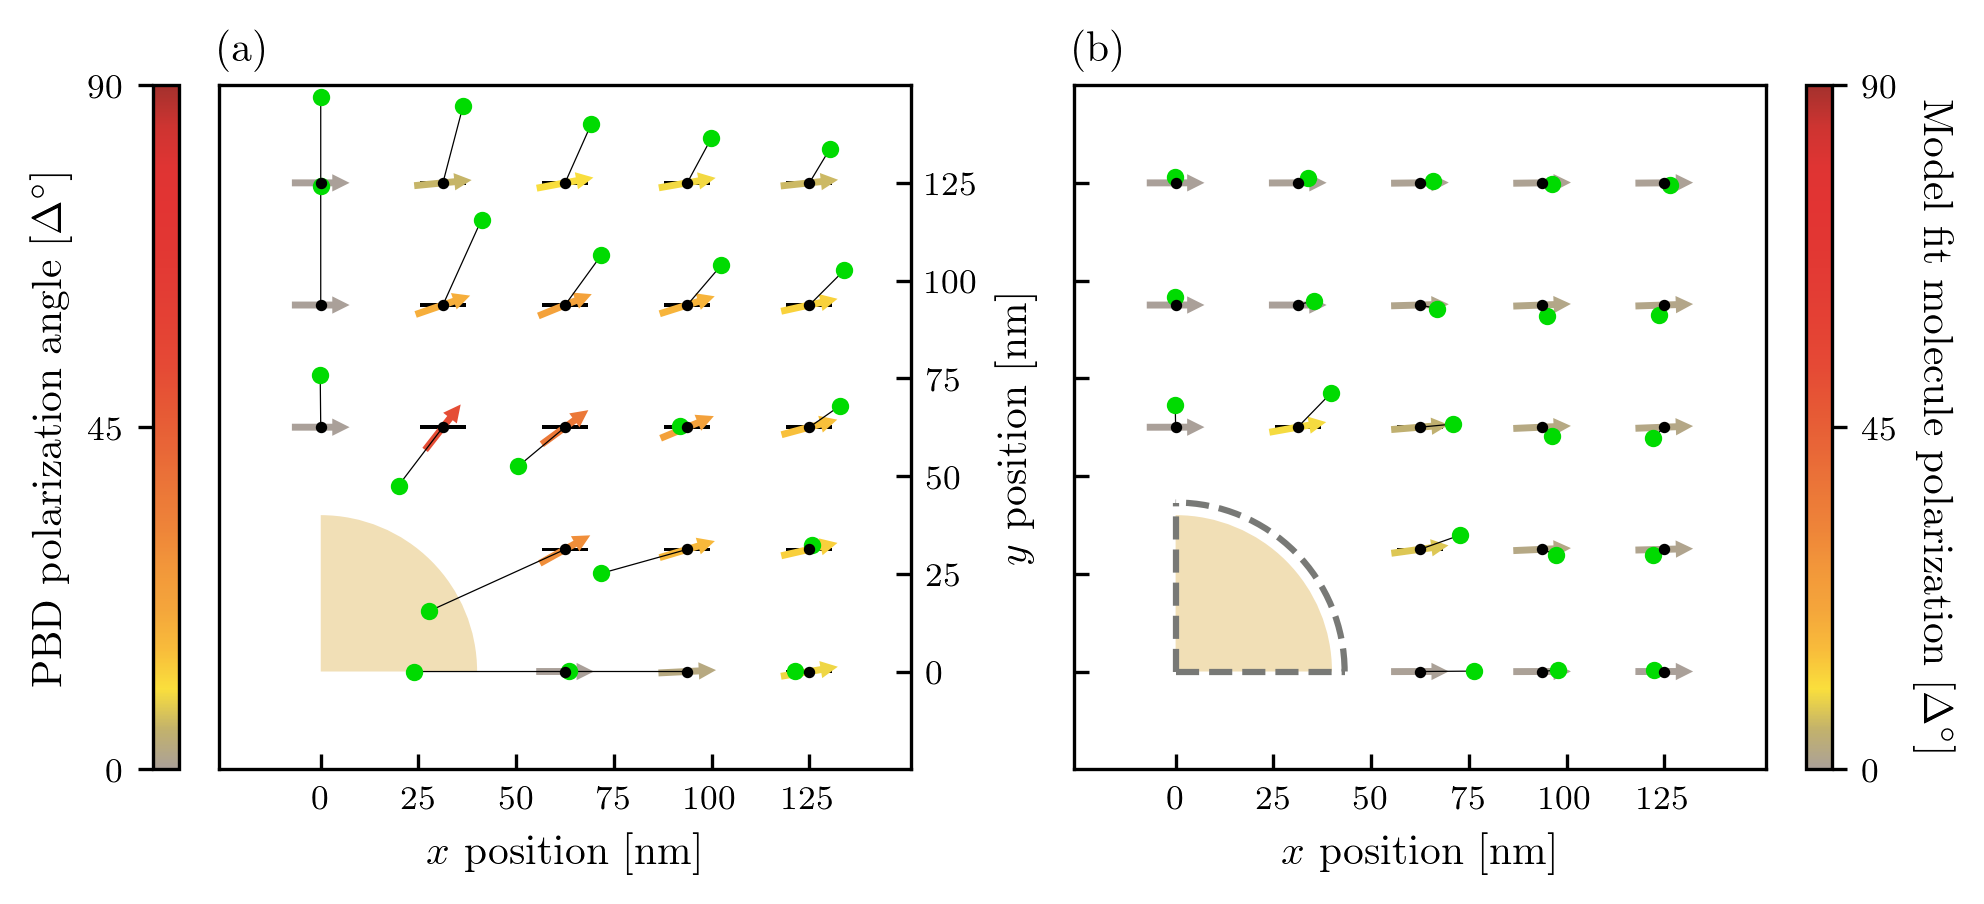

In [88]:
axs, fig5 = bem.fig5(sim_inst, mie_fit_mysims_inst_wGau, draw_quadrant=True)

## Maybe I need to compare the images

(-200, 200)

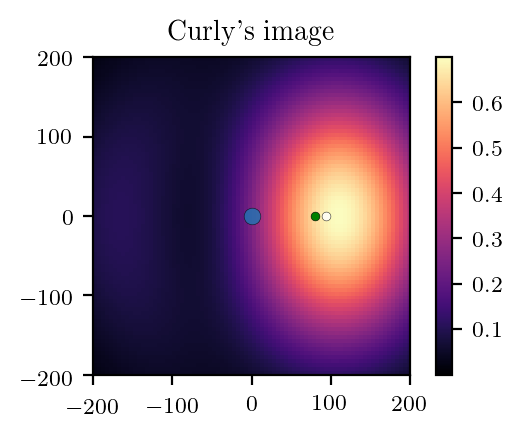

In [139]:
_img_idx = 2

fig, ax = plt.subplots()
_img = ax.imshow(
    curly_images[_img_idx]['E2_image_xy'].T, 
    origin='lower',
    extent=img_extent(curly_images[_img_idx])
    )
plt.colorbar(_img)
ax.set_title("Curly's image")

the_plas_loc=[0,0,0]

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *mie_the_fit_wGau[_img_idx-1, :2],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
ax.scatter(
    curly_images[_img_idx]['y_dip']*1e9, 
    curly_images[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )


ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

(-200, 200)

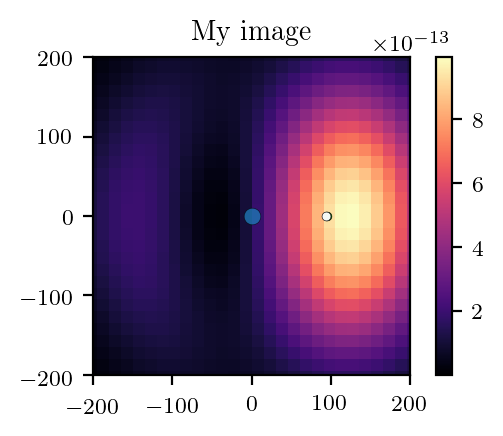

In [140]:
fig, ax = plt.subplots()
_img = ax.imshow(
    sim_inst.BEM_images[_img_idx-1].reshape((100,100)), 
    origin='lower',
    extent=img_extent(curly_images[1])
    )
plt.colorbar(_img)
ax.set_title("My image")

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *mie_fit_mysims_params_wGau[_img_idx-1, 1::-1],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
ax.scatter(
    curly_images[_img_idx]['y_dip']*1e9, 
    curly_images[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )
ax.scatter(
    sim_inst.mol_locations[_img_idx-1, 1], 
    sim_inst.mol_locations[_img_idx-1, 0],
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

In [141]:
print(    sim_inst.mol_locations[_img_idx-1, 1], 
    sim_inst.mol_locations[_img_idx-1, 0])

93.75 0.0


In [129]:
sim_inst.mol_locations[_img_idx]

array([125., 125.,   0.])

In [119]:
sim_inst.mol_locations

array([[  0.  ,  62.5 ,   0.  ],
       [  0.  ,  93.75,   0.  ],
       [  0.  , 125.  ,   0.  ],
       [ 31.25,  62.5 ,   0.  ],
       [ 31.25,  93.75,   0.  ],
       [ 31.25, 125.  ,   0.  ],
       [ 62.5 ,   0.  ,   0.  ],
       [ 62.5 ,  31.25,   0.  ],
       [ 62.5 ,  62.5 ,   0.  ],
       [ 62.5 ,  93.75,   0.  ],
       [ 62.5 , 125.  ,   0.  ],
       [ 93.75,   0.  ,   0.  ],
       [ 93.75,  31.25,   0.  ],
       [ 93.75,  62.5 ,   0.  ],
       [ 93.75,  93.75,   0.  ],
       [ 93.75, 125.  ,   0.  ],
       [125.  ,   0.  ,   0.  ],
       [125.  ,  31.25,   0.  ],
       [125.  ,  62.5 ,   0.  ],
       [125.  ,  93.75,   0.  ],
       [125.  , 125.  ,   0.  ]])

In [131]:
for idx in range(21):
    print(
        curly_images[idx+1]['y_dip']*1e9, 
        curly_images[idx+1]['x_dip']*1e9,)

[[62.5]] [[0.]]
[[93.75]] [[0.]]
[[125.]] [[0.]]
[[62.5]] [[31.25]]
[[93.75]] [[31.25]]
[[125.]] [[31.25]]
[[0.]] [[62.5]]
[[31.25]] [[62.5]]
[[62.5]] [[62.5]]
[[93.75]] [[62.5]]
[[125.]] [[62.5]]
[[0.]] [[93.75]]
[[31.25]] [[93.75]]
[[62.5]] [[93.75]]
[[93.75]] [[93.75]]
[[125.]] [[93.75]]
[[0.]] [[125.]]
[[31.25]] [[125.]]
[[62.5]] [[125.]]
[[93.75]] [[125.]]
[[125.]] [[125.]]


## Try running my own at Curly;s resolution

In [142]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)

sim_inst_highres = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmJC_curlySim_wGau',
    simulation_file_name='SphereJC_NoSub_dipDrive_E',
    sphere_model='Mie')
sim_inst_highres.trial_images = sim_inst_highres.calculate_BEM_fields()

mie_fit_mysims_inst_wGau_highres = fit.FitModelToData(
    sim_inst_highres.BEM_images, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim_wGau',
    sphere_model='Mie'
    )
mie_fit_mysims_params_wGau_highres = mie_fit_mysims_inst_wGau_highres.fit_model_to_image_data(
    check_ini=True)

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


In [149]:
bem.save_sim_exp_inst(sim_inst_highres, 'JC_sphere_highresImg')

In [152]:
bem.save_fit_inst(mie_fit_mysims_inst_wGau_highres, sim_inst_highres, 'JC_sphere_highresImg_fit')

## Loading sims after notebook crash on 2/26

In [27]:
sim_inst_highres = bem.LoadedSimExp('JC_sphere_highresImg','sphere_80nmJC_curlySim_wGau')

In [37]:
mie_fit_mysims_inst_wGau_highres = bem.LoadedFit('JC_sphere_highresImg_fit','sphere_80nmJC_curlySim_wGau')


AttributeError: 'LoadedFit' object has no attribute 'image_data'

In [41]:
mie_fit_mysims_inst_wGau_highres.__dict__.keys()

dict_keys(['parameters', 'drive_energy_eV', 'eps_inf', 'omega_plasma', 'gamma_drude', 'a_long_meters', 'a_short_meters', 'true_a_un_me', 'is_sphere', 'true_a_de_me', 'eps_b', 'fluo_quench_range', 'fluo_ext_coef', 'fluo_mass_hbar_gamma', 'fluo_nr_hbar_gamma', 'drive_amp', 'alpha0_diag_dyad', 'sphere_model', 'el_c', 'el_a', 'path_to_data', 'model_fit_results', 'loaded_sim_exp_instance', 'mol_angles'])

In [43]:
mie_fit_mysims_params_wGau_highres = mie_fit_mysims_inst_wGau_highres.model_fit_results

Calculating Gaussian centroid with BEM_images


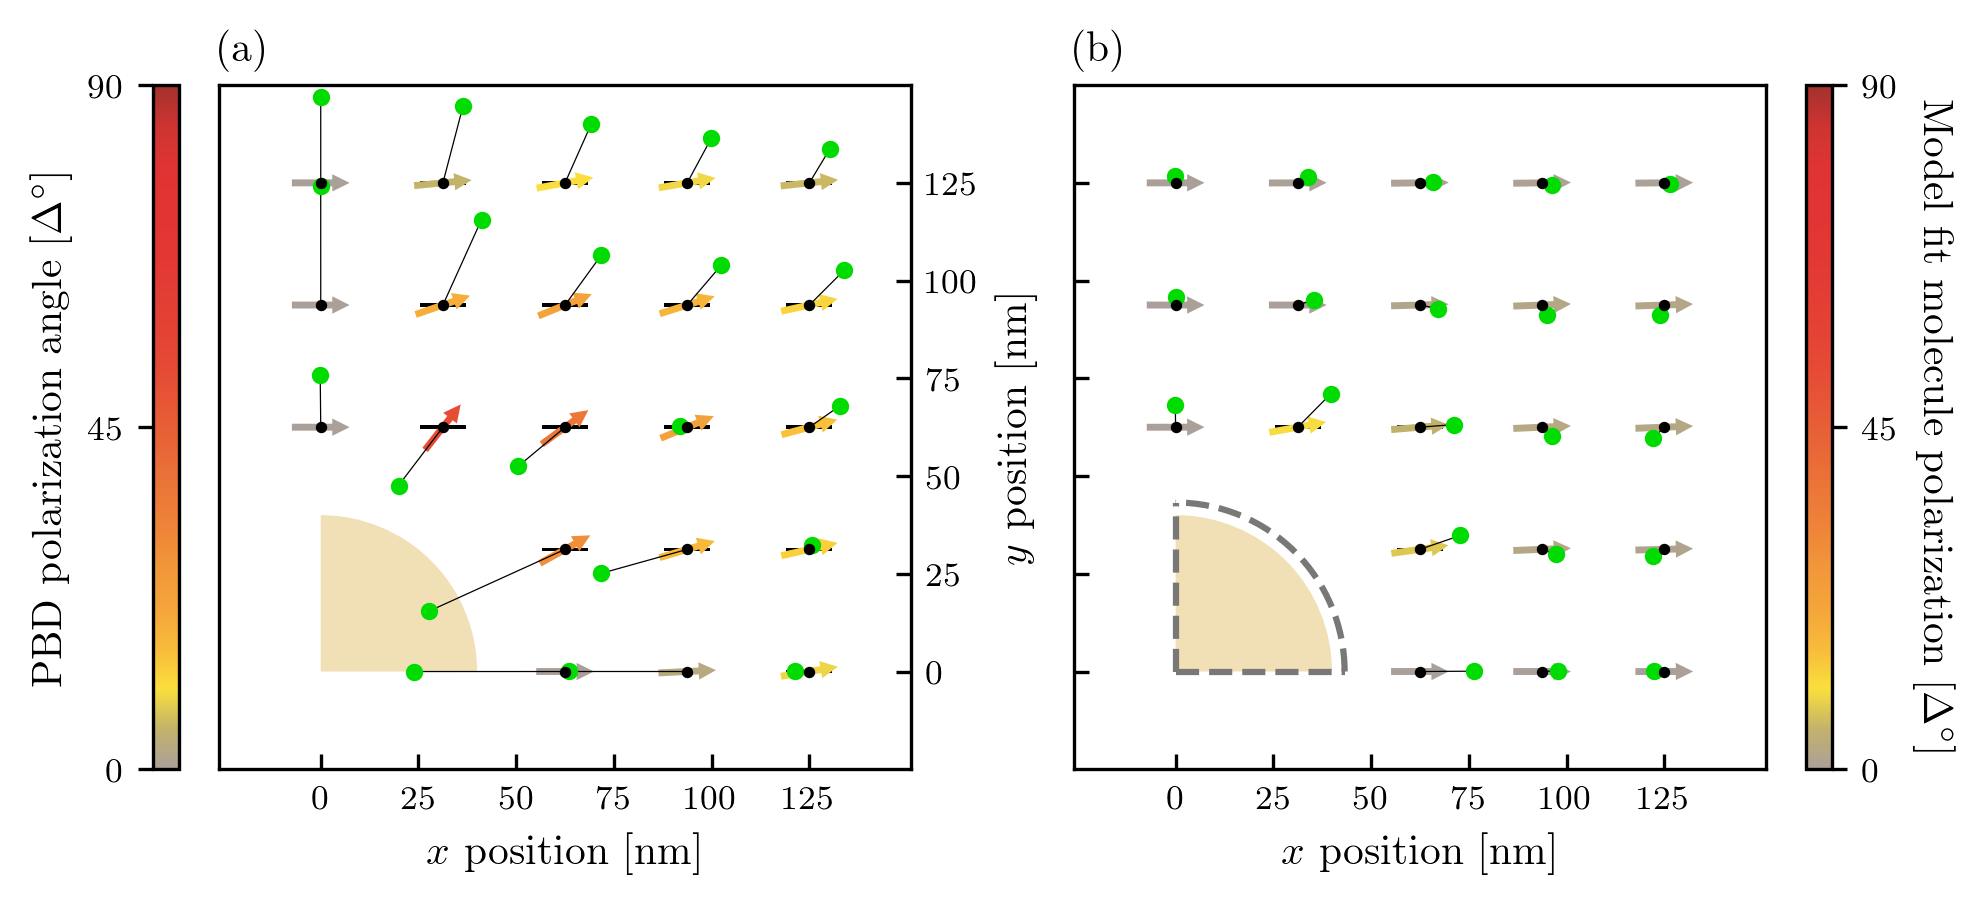

In [29]:
## Test loads look like preload plots
axs, fig5 = bem.fig5(
    sim_inst_highres, 
    mie_fit_mysims_inst_wGau_highres, 
    draw_quadrant=True)


Calculating Gaussian centroid with BEM_images


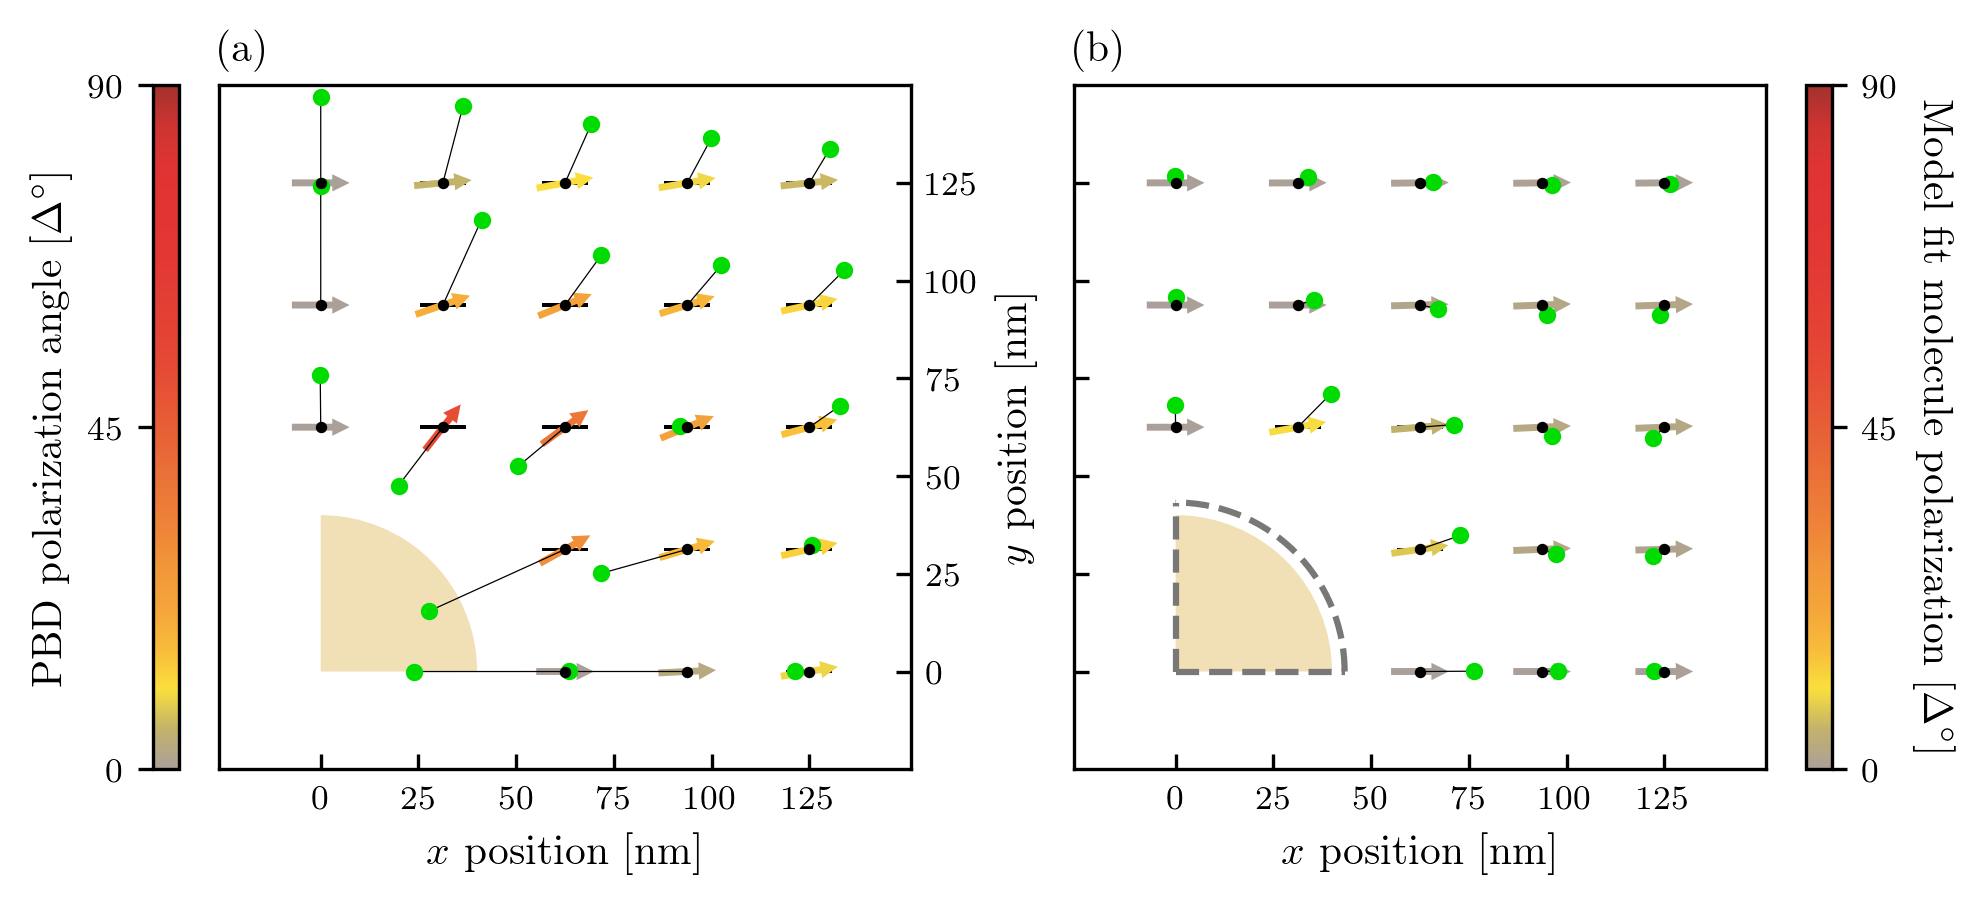

In [143]:
axs, fig5 = bem.fig5(
    sim_inst_highres, 
    mie_fit_mysims_inst_wGau_highres, 
    draw_quadrant=True)


(-200, 200)

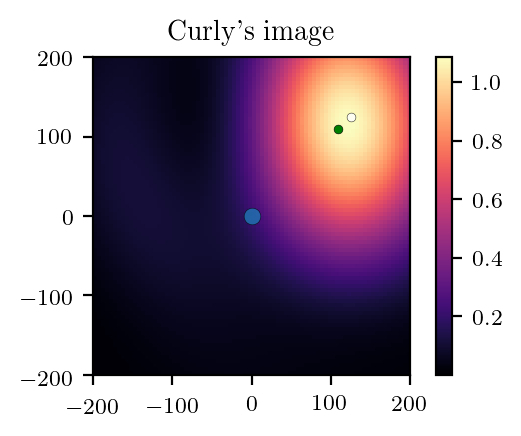

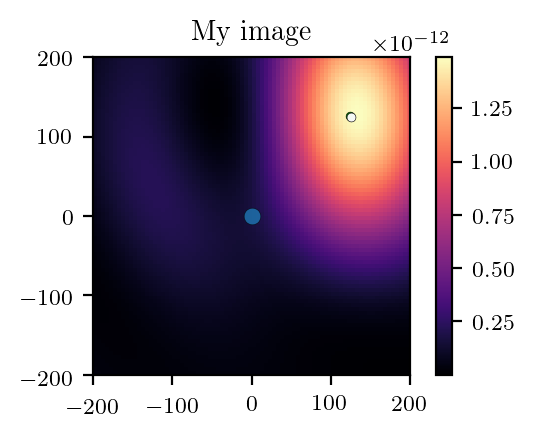

In [154]:
_img_idx = 21

fig, ax = plt.subplots()
_img = ax.imshow(
    curly_images[_img_idx]['E2_image_xy'].T, 
    origin='lower',
    extent=img_extent(curly_images[_img_idx])
    )
plt.colorbar(_img)
ax.set_title("Curly's image")

the_plas_loc=[0,0,0]

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *mie_the_fit_wGau[_img_idx-1, :2],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
ax.scatter(
    curly_images[_img_idx]['y_dip']*1e9, 
    curly_images[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )


ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

####
## Now plot my image
####

fig, ax = plt.subplots()
_img = ax.imshow(
    sim_inst_highres.BEM_images[_img_idx-1].reshape((300,300)), 
    origin='lower',
    extent=img_extent(curly_images[1])
    )
plt.colorbar(_img)
ax.set_title("My image")

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *mie_fit_mysims_params_wGau_highres[_img_idx-1, 1::-1],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
ax.scatter(
    curly_images[_img_idx]['y_dip']*1e9, 
    curly_images[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )
ax.scatter(
    sim_inst_highres.mol_locations[_img_idx-1, 1], 
    sim_inst_highres.mol_locations[_img_idx-1, 0],
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

# Try 2: fixing NA

In [14]:
path_to_data = os.path.join(
    os.sep,
    'Users',
    'chair',
    'Documents',
    'Academia',
    'SuperRes',
    'Biteen_colab',
    'from_Biteen_group',
    'simple_sphere_sims_011720',
#     'reanysimulationyouwantmetodo'
    )

def file_name_base_90d(numstr): 
    return f"AuNS_D40_{numstr:d}_X_01_16_20_ff_at558_90d"

In [15]:

curly_images_0219 = {}

for i in range(21):
    curly_images_0219[i+1] = sio.loadmat(
        os.path.join(path_to_data, "try2", file_name_base_90d(i+1)+".mat"))

In [205]:
array_of_curly_imgs_0219 = np.empty((21, 300**2))
for i in range(21):
    array_of_curly_imgs_0219[i] = curly_images_0219[i+1]['E2_image_xy'].ravel()

In [206]:
for i in range(21):
    print(np.any(array_of_curly_imgs_0219[i] - array_of_curly_imgs[i] != 0))

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [207]:
array_of_curly_imgs_0219[0] - array_of_curly_imgs[0]

array([ 1.79856092e-04,  1.99256823e-04,  2.20138970e-04, ...,
       -9.83414410e-05, -8.21010986e-05, -6.63738498e-05])

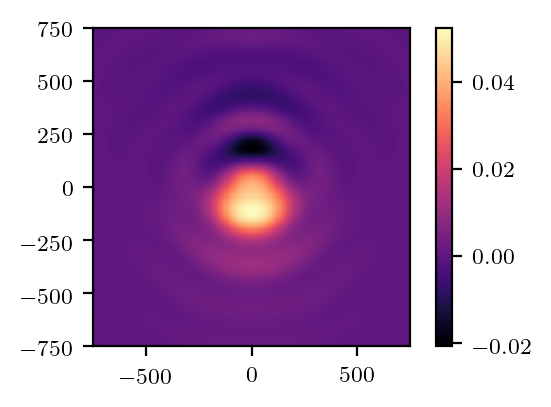

In [188]:
fig, ax = plt.subplots()
_img = ax.imshow(
    (array_of_curly_imgs_0219[0] - array_of_curly_imgs[0]).reshape((300,300)), 
    origin='lower',
    extent=img_extent(curly_images_0219[_img_idx])
    )
plt.colorbar(_img)

In [209]:
fit_inst_0219 = fit.FitModelToData(
    array_of_curly_imgs_0219[0,None], 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim',
    sphere_model='MLWA'
    )
the_fit_0219 = fit_inst_0219.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (21.728200396792893,-5.393648320996347e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  21.728200396792893 
 ini_y,  -5.393648320996347e-06 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? True
Params modified, OG params: (21.728200396792893, -5.393648320996347e-06, array([1.01820902]))
but now they are: (52.202153529998384, -1.2958277829193594e-05, array([1.01820902]))


(-200, 200)

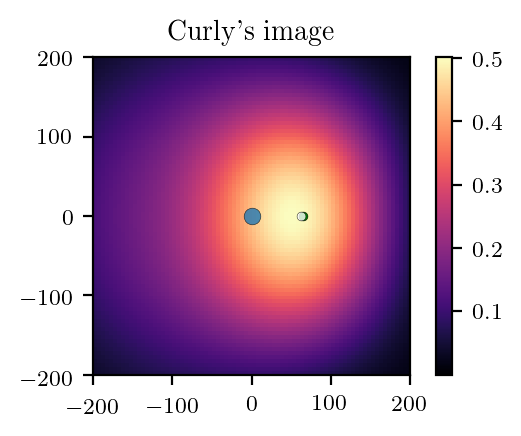

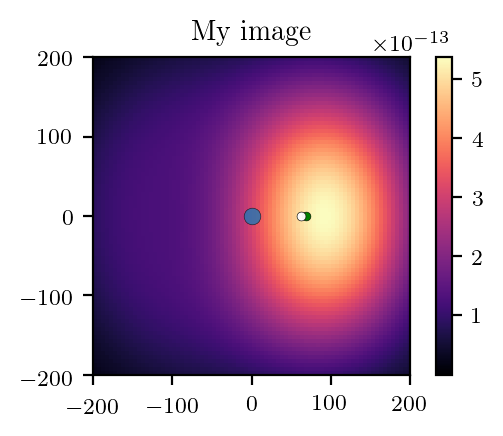

In [211]:
_img_idx = 1

fig, ax = plt.subplots()
_img = ax.imshow(
    curly_images_0219[_img_idx]['E2_image_xy'].T, 
    origin='lower',
    extent=img_extent(curly_images_0219[_img_idx])
    )
plt.colorbar(_img)
ax.set_title("Curly's image")

the_plas_loc=[0,0,0]

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *the_fit_0219[_img_idx-1, :2],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
ax.scatter(
    curly_images_0219[_img_idx]['y_dip']*1e9, 
    curly_images_0219[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )


ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

####
## Now plot my image
####

fig, ax = plt.subplots()
_img = ax.imshow(
    sim_inst_highres.BEM_images[_img_idx-1].reshape((300,300)), 
    origin='lower',
    extent=img_extent(curly_images_0219[1])
    )
plt.colorbar(_img)
ax.set_title("My image")

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *mie_fit_mysims_params_wGau_highres[_img_idx-1, 1::-1],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
ax.scatter(
    curly_images_0219[_img_idx]['y_dip']*1e9, 
    curly_images_0219[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )
ax.scatter(
    sim_inst_highres.mol_locations[_img_idx-1, 1], 
    sim_inst_highres.mol_locations[_img_idx-1, 0],
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

In [212]:
the_fit_0219[_img_idx-1, :2] - mie_fit_mysims_params_wGau_highres[_img_idx-1, 1::-1]

array([-3.72932966,  0.65461828])

# Try 3 on 02/20/20

In [30]:

curly_images_0220 = {}

for i in range(21):
    curly_images_0220[i+1] = sio.loadmat(
        os.path.join(path_to_data, "try3", file_name_base_90d(i+1)+".mat"))

In [31]:
array_of_curly_imgs_0220 = np.empty((21, 300**2))
for i in range(21):
    array_of_curly_imgs_0220[i] = curly_images_0220[i+1]['E2_image_xy'].ravel()

In [33]:
for i in range(21):
    print(np.any(array_of_curly_imgs_0220[i] - array_of_curly_imgs[i] != 0))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


(-200, 200)

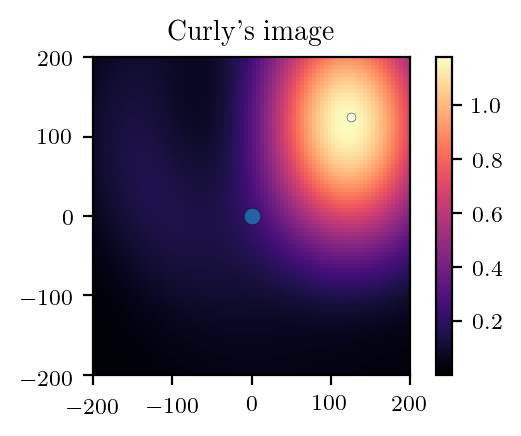

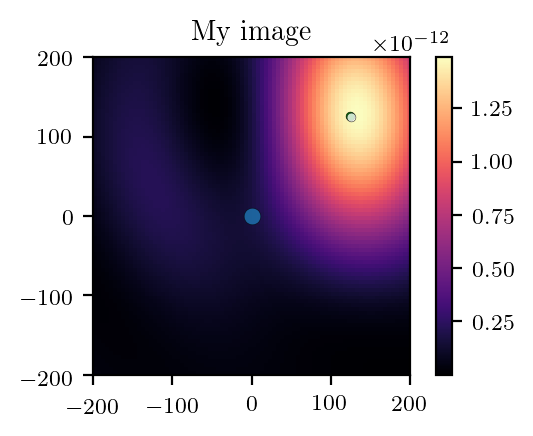

In [44]:
_img_idx = 21

#######################
the_plas_loc=[0,0,0]

fig, ax = plt.subplots()

## Plot Curly image
_img = ax.imshow(
    curly_images_0220[_img_idx]['E2_image_xy'].T, 
    origin='lower',
    extent=img_extent(curly_images_0220[_img_idx])
    )
plt.colorbar(_img)
ax.set_title("Curly's image")

## Mark plasmon position in Curly image
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions in Curly image
# ax.scatter(
#     *the_fit_0220[_img_idx-1, :2],  
#     zorder=5,
#     s = 10,
#     c='green',
#     edgecolor='k',
#     linewidth=.2,
#     label='Predicted mol. pos.'
#     )

## Mark true molecule postion in Curly image
ax.scatter(
    curly_images_0220[_img_idx]['y_dip']*1e9, 
    curly_images_0220[_img_idx]['x_dip']*1e9,
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

####
## Now plot my image
####

fig, ax = plt.subplots()
## Plot image
_img = ax.imshow(
    sim_inst_highres.BEM_images[_img_idx-1].reshape((300,300)), 
    origin='lower',
    extent=img_extent(curly_images_0220[1])
    )
plt.colorbar(_img)
ax.set_title("My image")

## Mark plasmon position
ax.scatter(
    the_plas_loc[1], 
    the_plas_loc[0], 
    zorder=5,
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='Nanoparticle pos.'
    )

## Mark predicted molecule postions
ax.scatter(
    *mie_fit_mysims_params_wGau_highres[_img_idx-1, 1::-1],  
    zorder=5,
    s = 10,
    c='green',
    edgecolor='k',
    linewidth=.2,
    label='Predicted mol. pos.'
    )

## Mark true molecule postion
# ax.scatter(
#     curly_images_0220[_img_idx]['y_dip']*1e9, 
#     curly_images_0220[_img_idx]['x_dip']*1e9,
#     zorder=5,
#     s = 10,
#     c='w',
#     alpha=.8,
#     edgecolor='k',
#     linewidth=.2,
#     label='True mol. pos.'
#     )
ax.scatter(
    sim_inst_highres.mol_locations[_img_idx-1, 1], 
    sim_inst_highres.mol_locations[_img_idx-1, 0],
    zorder=5,
    s = 10,
    c='w',
    alpha=.8,
    edgecolor='k',
    linewidth=.2,
    label='True mol. pos.'
    )

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])

In [45]:
fit_inst_0220 = fit.FitModelToData(
    array_of_curly_imgs_0220, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_curlySim',
    sphere_model='Mie'
    )
the_fit_0220 = fit_inst_0220.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (21.72816971427038,2.3811537288480774e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  21.72816971427038 
 ini_y,  2.3811537288480774e-06 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? True
Params modified, OG params: (21.72816971427038, 2.3811537288480774e-06, array([1.56610457]))
but now they are: (52.20215352999968, 5.720746570986088e-06, array([1.56610457]))

 initial guess for molecule 1 location: (104.85729011584421,-7.172937363496314e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  104.85729011584421 
 ini_y,  -7.172937363496314e-07 
 self.quel_a,  52.20215352999999 
 self.quel_c,  52.20215352999999 

In quenching zone? False

 initial guess for molecule 2 location: (127.38896542996541,7.254124376704345e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  127.38896542996541 
 ini_y,  7.254124376704345e-07 
 self.quel_a,  52.202153

In [46]:
fit_inst_0220.__dict__.keys()

dict_keys(['mol_angles', 'rod_angle', 'image_data', 'ini_guess', 'parameters', 'drive_energy_eV', 'eps_inf', 'omega_plasma', 'gamma_drude', 'a_long_meters', 'a_short_meters', 'true_a_un_me', 'is_sphere', 'true_a_de_me', 'eps_b', 'fluo_quench_range', 'fluo_ext_coef', 'fluo_mass_hbar_gamma', 'fluo_nr_hbar_gamma', 'drive_amp', 'alpha0_diag_dyad', 'sphere_model', 'alpha1_diag_dyad', 'el_c', 'el_a', 'sensor_size', 'obs_points', 'drive_I', 'quel_a', 'quel_c', 'model_fit_results', 'x_gau_cen', 'y_gau_cen'])

## Plot fits on top of fit scatter plot

In [47]:
def connectpoints( cen_x, cen_y, mol_x, mol_y, p, ax=None, zorder=1, ls='k-'):
    x1, x2 = mol_x[p], cen_x[p]
    y1, y2 = mol_y[p], cen_y[p]
    if ax is None:
        plt.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)
    else:
        ax.plot([x1,x2],[y1,y2], ls, linewidth=.3, zorder=zorder)

def scatter_prevCents_wLine(
#     self,
    ax,
    x_plot, 
    y_plot,
    x_mol_loc,
    y_mol_loc,
#     est_locs,
    ):
    
#     if est_locs == 'gauss':
#         x_plot, y_plot = og_gau_cents

#     elif est_locs == 'model':
#         x_plot, y_plot = fit_inst.model_fit_results[:,:2].T
    
    for i in np.arange(x_plot.shape[0]):
        connectpoints(
            cen_x=x_plot,
            cen_y=y_plot,
            mol_x=x_mol_loc,
            mol_y=y_mol_loc,
            p=i,
            ax=ax,
            zorder=1,
            ls='k--'
            )
    localization_handle = ax.scatter(
        x_plot,
        y_plot,
        s=10,
        alpha=.5,
#         c=['C2'],
        zorder=2,
        facecolors='none', edgecolors='C4' 
        )
    return ax

In [48]:
import matplotlib as mpl

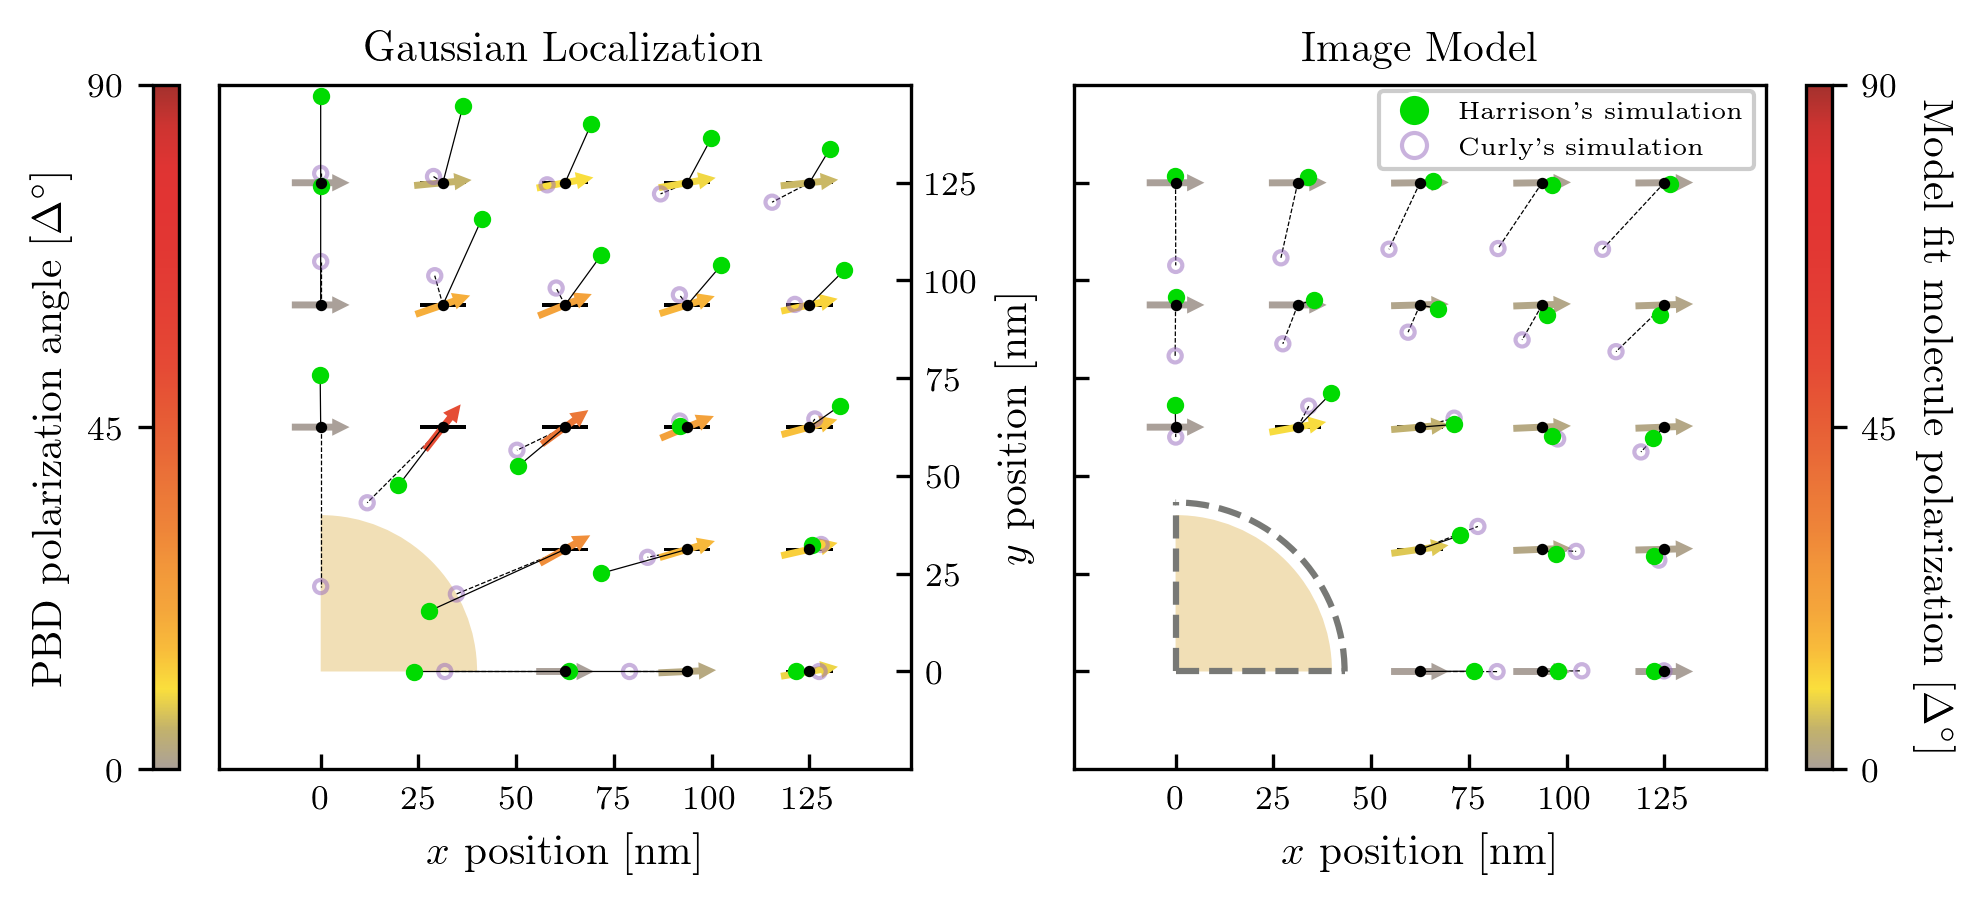

In [49]:
axs, fig5 = bem.fig5(
    sim_inst_highres, 
    mie_fit_mysims_inst_wGau_highres, 
    draw_quadrant=True,
    show_ax_labels=True,
#     show_legend=True
    )

## Plot Curly Gaussian fits
scatter_prevCents_wLine(
    axs[1],
    fit_inst_0220.y_gau_cen,
    fit_inst_0220.x_gau_cen,
    sim_inst_highres.mol_locations[:,0],
    sim_inst_highres.mol_locations[:,1],
#     est_locs='gauss'
    )

scatter_prevCents_wLine(
    axs[2],
    fit_inst_0220.model_fit_results[:,1].T,
    fit_inst_0220.model_fit_results[:,0].T,
    sim_inst_highres.mol_locations[:,0],
    sim_inst_highres.mol_locations[:,1],
#     est_locs='model'
    )

legend_elements = [
    mpl.lines.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label="Harrison's simulation",
        markerfacecolor=fit.PlottableDipoles.a_shade_of_green,
        markersize=8,
        ),
    mpl.lines.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label="Curly's simulation",
#         markerfacecolor='black',
        markersize=6,
#         s=10,
        alpha=.5,
#         c=['C2'],
#         zorder=2,
        markerfacecolor='none', 
        markeredgecolor='C4' 
        )
    ] 
axs[2].legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.,1.01),
#         ncol=2, mode="expand",
    fontsize=6,
    framealpha=1,
#         loc=1
    )

# loc_map_legend(axs[2], loc_label='fit localization')

# Try fitting Curly's new images with my parameters for the hell of it

In [50]:
fit_inst_myparams_0226 = fit.FitModelToData(
    array_of_curly_imgs_0220, 
#     ini_guess=simTestInst_few_mol.mol_locations,
    ini_guess='gauss',
    param_file='sphere_80nmJC_bemSim_wGau',
    sphere_model='Mie'
    )
the_fit_myparams_0226 = fit_inst_myparams_0226.fit_model_to_image_data(
    check_ini=True)


 initial guess for molecule 0 location: (21.72816971427038,2.3811537288480774e-06)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  21.72816971427038 
 ini_y,  2.3811537288480774e-06 
 self.quel_a,  51.65820063999999 
 self.quel_c,  51.65820063999999 

In quenching zone? True
Params modified, OG params: (21.72816971427038, 2.3811537288480774e-06, array([0.59811466]))
but now they are: (51.65820063999968, 5.661135684847892e-06, array([0.59811466]))

 initial guess for molecule 1 location: (104.85729011584421,-7.172937363496314e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  104.85729011584421 
 ini_y,  -7.172937363496314e-07 
 self.quel_a,  51.65820063999999 
 self.quel_c,  51.65820063999999 

In quenching zone? False

 initial guess for molecule 2 location: (127.38896542996541,7.254124376704345e-07)
Checking inital guess
self.rod_angle,  1.5707963267948966 
 ini_x,  127.38896542996541 
 ini_y,  7.254124376704345e-07 
 self.quel_a,  51.658200

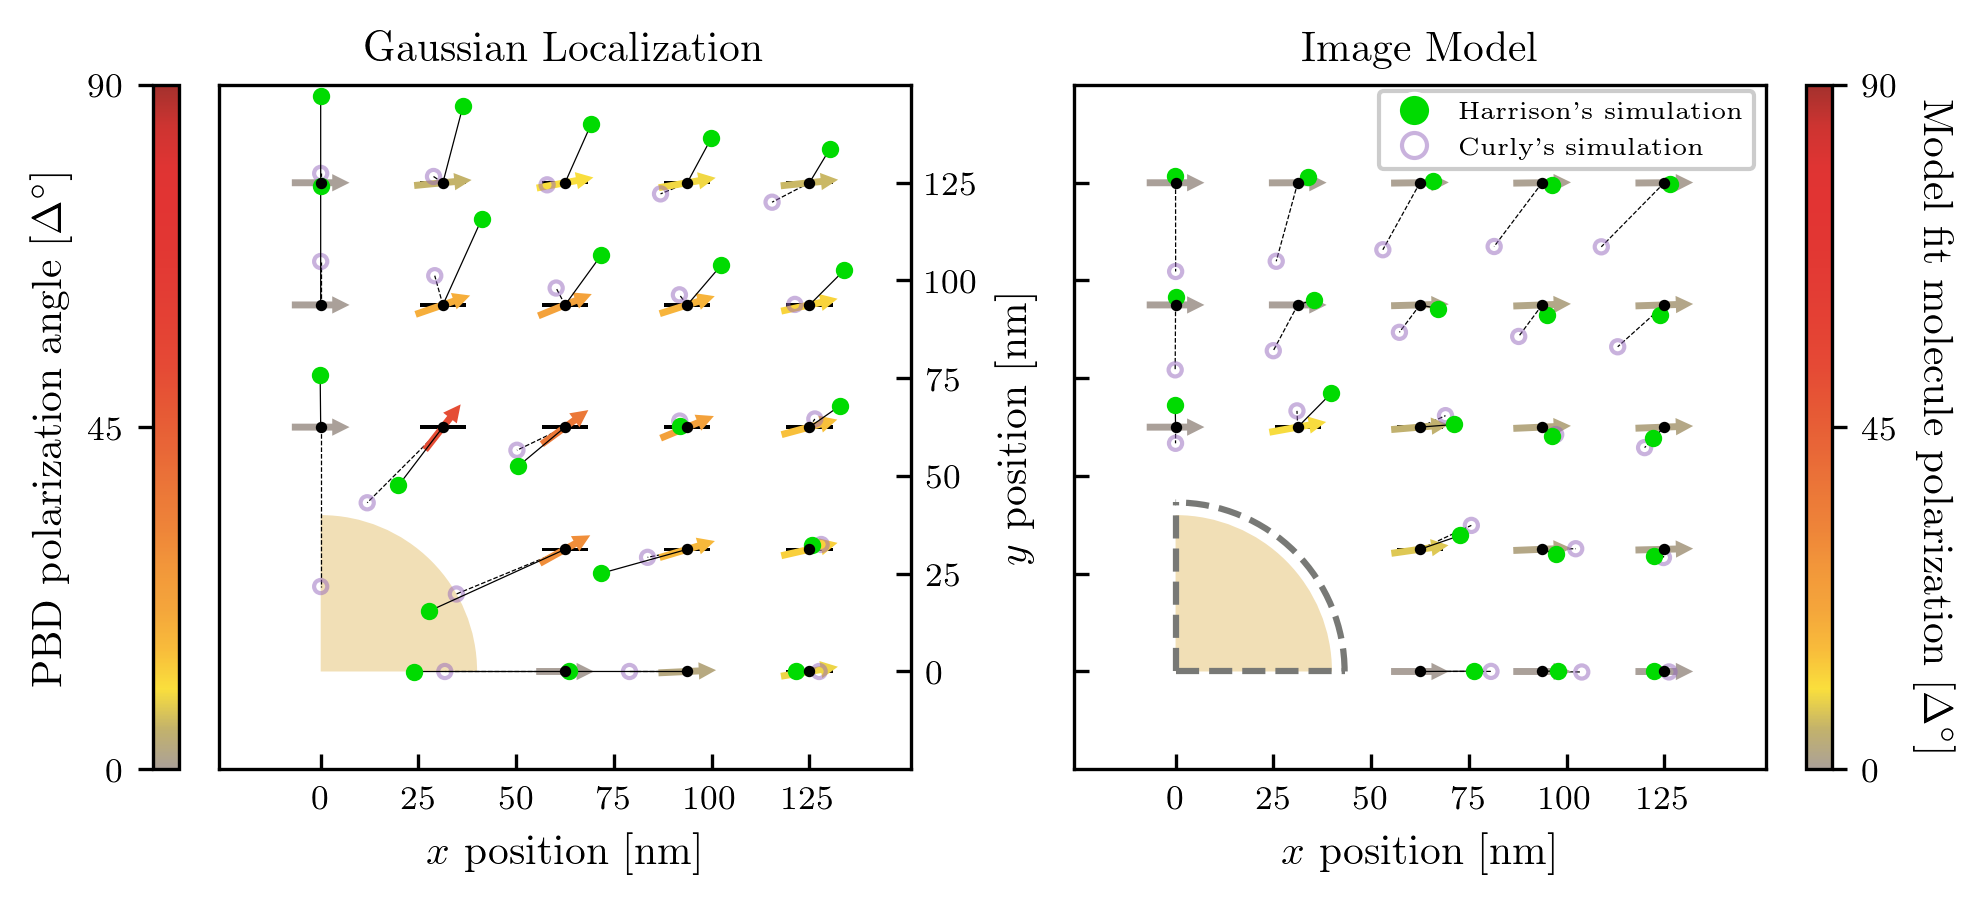

In [52]:
axs, fig5 = bem.fig5(
    sim_inst_highres, 
    mie_fit_mysims_inst_wGau_highres, 
    draw_quadrant=True,
    show_ax_labels=True,
#     show_legend=True
    )

## Plot Curly Gaussian fits
scatter_prevCents_wLine(
    axs[1],
    fit_inst_myparams_0226.y_gau_cen,
    fit_inst_myparams_0226.x_gau_cen,
    sim_inst_highres.mol_locations[:,0],
    sim_inst_highres.mol_locations[:,1],
#     est_locs='gauss'
    )

scatter_prevCents_wLine(
    axs[2],
    fit_inst_myparams_0226.model_fit_results[:,1].T,
    fit_inst_myparams_0226.model_fit_results[:,0].T,
    sim_inst_highres.mol_locations[:,0],
    sim_inst_highres.mol_locations[:,1],
#     est_locs='model'
    )

legend_elements = [
    mpl.lines.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label="Harrison's simulation",
        markerfacecolor=fit.PlottableDipoles.a_shade_of_green,
        markersize=8,
        ),
    mpl.lines.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label="Curly's simulation",
#         markerfacecolor='black',
        markersize=6,
#         s=10,
        alpha=.5,
#         c=['C2'],
#         zorder=2,
        markerfacecolor='none', 
        markeredgecolor='C4' 
        )
    ] 
axs[2].legend(
    handles=legend_elements,
    loc='upper right',
    bbox_to_anchor=(1.,1.01),
#         ncol=2, mode="expand",
    fontsize=6,
    framealpha=1,
#         loc=1
    )

# loc_map_legend(axs[2], loc_label='fit localization')

In [ ]:
v

## Generate just an image of a dipole

In [54]:
locations, angles = fit.fixed_ori_mol_placement(
    mol_grid_pts_1D=5, x_max=125, y_max=125)

In [55]:
sim_inst_highres_justEdip = bem.SimulatedExperiment(
    locations, 
    mol_angle=0,
    param_file='sphere_80nmJC_curlySim_wGau',
    simulation_file_name='SphereJC_NoSub_dipDrive_justEdip',
    sphere_model='Mie')
sim_inst_highres_justEdip.trial_images = sim_inst_highres_justEdip.calculate_BEM_fields()

starting Matlab...
given even number of points for Fibonacci lattice, 
  adding 1...
1th molecule
calculating diffracted fields
2th molecule
calculating diffracted fields
3th molecule
calculating diffracted fields
4th molecule
calculating diffracted fields
5th molecule
calculating diffracted fields
6th molecule
calculating diffracted fields
7th molecule
calculating diffracted fields
8th molecule
calculating diffracted fields
9th molecule
calculating diffracted fields
10th molecule
calculating diffracted fields
11th molecule
calculating diffracted fields
12th molecule
calculating diffracted fields
13th molecule
calculating diffracted fields
14th molecule
calculating diffracted fields
15th molecule
calculating diffracted fields
16th molecule
calculating diffracted fields
17th molecule
calculating diffracted fields
18th molecule
calculating diffracted fields
19th molecule
calculating diffracted fields
20th molecule
calculating diffracted fields
21th molecule
calculating diffracted fields


In [60]:
sim_inst_highres_justEdip.mispol_angle = 0

In [61]:
bem.save_sim_exp_inst(sim_inst_highres_justEdip, 'highres_sim_justDipoleField')